In [9]:
import matplotlib.pyplot as plt
import pickle
import glob
import sys
import corner
from scipy.stats import multivariate_normal
import numpy as np
from astropy.table import Table
import math, scipy
from scipy.interpolate import interp1d
import pyccl as ccl
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import abundance as cl_count
import forecast
import utils
import covariance as covar

def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
MLE = [Omega_c_true + Omega_b_true, sigma8_true]
Om_true, s8_true = MLE
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

# Compute Fisher Matrix

In [11]:
n_logm_bin = 4
n_z_bin = n_logm_bin
logm_corner = np.linspace(14.2, 15.6, n_logm_bin + 1)
logMass_bin = binning(logm_corner)
z_corner = np.linspace(0.2,1.2, n_z_bin + 1)
Z_bin = binning(z_corner)

In [12]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)
halobias = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def= massdef, mass_def_strict=True)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi 
clc.f_sky = clc.sky_area/(4*np.pi)
print(clc.f_sky)
z_grid = np.linspace(0., 2.1, 2000)
logm_grid = np.linspace(14.1, 15.7, 2001)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
clc.compute_halo_bias_grid_MZ(z_grid = z_corner, logm_grid = logm_corner, halobiais = halobias)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

0.25


In [13]:
Halo_bias=NHalo_bias/Abundance

In [14]:
Covariance = covar.Covariance_matrix()
#use PySSC from Lacasa et al.
Sij = Covariance.matter_fluctuation_amplitude_fullsky(Z_bin)

In [15]:
Sample_covariance = Covariance.sample_covariance_full_sky(Z_bin, logMass_bin, NHalo_bias, Sij)/clc.f_sky

## Covariance matrix

In [16]:
Covariance_prediction = Sample_covariance + np.diag(Abundance.flatten())

## Define model

In [17]:
def model(theta):
    Om, s8 = theta
    cosmox = ccl.Cosmology(Omega_c = Om-Omega_b_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = s8, n_s=0.96)
    massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
    hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmox, mass_def=massdef)
    clc.set_cosmology(cosmo = cosmox, hmd = hmd, massdef = massdef)
    clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
    return clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps').flatten()

In [20]:
Forecast = forecast.Forecast()
F = Forecast.Fisher_Matrix_Gaussian(MLE, model, Covariance_prediction, delta = 1e-4)

In [21]:
cov = np.linalg.inv(F)

# Proposal

## Limits of proposal

In [22]:
n = 6 * 2
widthOm_macro = n * cov[0,0]**.5
widths8_macro = n * cov[1,1]**.5

In [23]:
std_Om = widthOm_macro
std_s8 = widths8_macro
Om_limit = [Om_true-std_Om/2, Om_true+std_Om/2]
s8_limit = [s8_true-std_s8/2, s8_true+std_s8/2]

In [24]:
Om_limit

[0.29309132294265433, 0.32112867705734566]

In [25]:
s8_limit

[0.8207287639732547, 0.8368712360267453]

## Multi-variate gaussian

In [101]:
q = Proposal(MLE, 6**2*cov, .9, 0.1, Om_limit, s8_limit,)

In [102]:
q.norm

{'gaussian': 0.6027630294866283, 'uniform': 0.0045259220525059865}

## Random samples $X \sim q$

In [103]:
qmax = q.q(MLE)
rand, q_val = imp_sampling.compute_position_from_distribution(ndim = 2, pdf = q.q, pdf_max = qmax, N_points = 10000, limits = [Om_limit, s8_limit])

acceptance = 0.41240514681623225


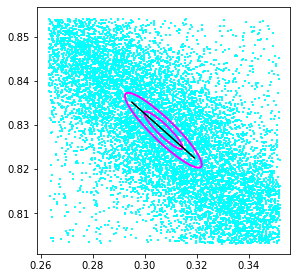

In [104]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
x = np.linspace(0.295, 0.319, 100)
ax[1,0].plot(x, q.mean_s8(x), 'k')
ax[1,0].scatter(rand[:,0], rand[:,1], s = 1, c = 'cyan', marker = 's')
pos2d = [rand[:,0], rand[:,1]]
binsx = np.linspace(Om_limit[0], Om_limit[1], 20)
binsy = np.linspace(s8_limit[0], s8_limit[1], 20)
#utils._plot_contours(ax, pos2d, binsx = binsx, binsy = binsy)
utils._make_ellipse(MLE, cov, ax[1,0], level=0.95, color='magenta', label = 'Fisher forecast', ls = '-')
#utils._make_ellipse(MLE, 9*cov, ax[1,0], level=0.95, color='blue', label = 'used for q', ls = '-')
#corner.corner(rand, fig = fig, levels = [sigma1, sigma2, sigma3], fill_countours = False, plot_density = False)
fig.delaxes(ax[0,0])
fig.delaxes(ax[0,1])
fig.delaxes(ax[1,1])

In [70]:
res = np.zeros([len(q_val), 3])
res[:,0] = rand[:,0]
res[:,1] = rand[:,1]
res[:,2] = q_val

In [40]:
rand_Table = Table(res, names = ['Om', 's8','q'])

## save

In [41]:
#name = '/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/pinocchio_analysis/proposal_Oms8.pkl'
#f = open(name,'wb')
#pickle.dump(rand_Table, f)
#f.close()

In [22]:
#mask = (abs(Om_ind - MLE[0]) > 0.004)*(abs(s8_ind - MLE[1]) > 0.0001)
#sampler_tension = np.array(sampler_BG)[mask]
#from chainconsumer import ChainConsumer
##c = ChainConsumer()
#labels = ['a','b']
#c.add_chain(np.array([Om_ind, s8_ind]).T, name="PINOCCHIO-1000" + str(i), parameters = labels)
#for i, s in enumerate(sampler_tension[0:3]):
#    data_single = np.array(load(s))
#    c.add_chain(data_single[1000:,:], name="PINOCCHIO-" + str(i), parameters = labels)
#c.configure(kde = [1.5,1.5,1.5,1.5], smooth=[1,1,1,1],linestyles=["-", "-", "-","-"],
#            linewidths=[2, 1.3, 1.3, 1.3],
#             colors=["#1E88E5", "g","r",'k'], shade=[True, False, False,False], shade_alpha = [0.5,1, 1,1],
#            bar_shade=False,flip=True,label_font_size=20, tick_font_size=20)
#fig = c.plotter.plot(truth = MLE)
#fig.set_size_inches(5 + fig.get_size_inches())  
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/ind_1000.png', bbox_inches='tight', dpi=300)